In [21]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

In [22]:
#Load the data
print("-------------------------------- Load IS --------------------------------")
experiment_ext = ""
name_experiment_is = "playground_is_phi_phi" + experiment_ext
path_start = "./outputs/" + name_experiment_is + "/"
lst_data_is = []
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_is.append(json.load(file))
                    print("Loaded: " + path)
print("-------------------------------- Load Metropolis --------------------------------")
name_experiment_m = "/playground_metropolis_phi_phi"
path_start = "./outputs/" + name_experiment_m + "/"
lst_data_m = []             
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_m.append(json.load(file))
                    print("Loaded: " + path)

-------------------------------- Load IS --------------------------------
Loaded: ./outputs/playground_is_phi_phi/2024-09-13/01-12-37_442/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-13/00-57-47_438/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-13/01-07-11_440/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-13/01-07-39_441/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-13/01-12-53_443/all.json
Loaded: ./outputs/playground_is_phi_phi/2024-09-13/01-05-55_439/all.json
-------------------------------- Load Metropolis --------------------------------
Loaded: ./outputs//playground_metropolis_phi_phi/2024-09-13/01-38-02_439/all.json
Loaded: ./outputs//playground_metropolis_phi_phi/2024-09-13/01-21-57_438/all.json


In [23]:
# For fair comparison it is better to compare with the same true rule
true_rule = lst_data_m[0]["true_rules"]
for data in lst_data_m + lst_data_is:
    assert data["true_rules"] == true_rule
    print(len(data["rules"]))

603
603
201
201
201
201
201
201


In [24]:
# Reconstruct all rules IS
all_rules_is = []
all_likelihoods_is = []
all_weights_is = []
for data in lst_data_is:
    all_rules_is.append(np.repeat(data["rules"], data["metrics"]["counts"]))
    all_likelihoods_is.append(np.repeat(data["metrics"]["test_likelihoods"], data["metrics"]["counts"]))
    all_weights_is.append(np.repeat(data["metrics"]["weights"], data["metrics"]["counts"]))
all_rules_is = np.stack(all_rules_is)
all_likelihoods_is = np.stack(all_likelihoods_is)
all_weights_is = np.stack(all_weights_is)

In [25]:
# Reconstruct all rules Metropolis
all_rules_m = []
all_likelihoods_m = []
all_weights_m = []
all_prev_rules_ind_m = []
for data in lst_data_m:
    nb_particles = data["metrics"]["nb_rules"]
    rules = np.array(data["rules"])
    likelihoods = np.array(data["metrics"]["test_likelihoods"])
    weights =  np.array(data["metrics"]["weights"])
    prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
    all_rules_m.append(rules.reshape((-1, nb_particles)).transpose())
    all_likelihoods_m.append(likelihoods.reshape((-1, nb_particles)).transpose())
    all_weights_m.append(weights.reshape((-1, nb_particles)).transpose())
    all_prev_rules_ind_m.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
# Concatenate all seeds
all_rules_m = np.concatenate(all_rules_m, axis=0)
all_likelihoods_m = np.concatenate(all_likelihoods_m, axis=0)
all_weights_m = np.concatenate(all_weights_m, axis=0)
all_prev_rules_ind_m = np.concatenate(all_prev_rules_ind_m, axis=0)

In [26]:
# Get the likelihood without the rule for each seed in IS:
for i in range(len(all_rules_is)):
    assert (all_rules_is[i][-1]) is None
    print(f"For seed {i} the likelihood without the rule is {all_likelihoods_is[i][-1]}")

For seed 0 the likelihood without the rule is -303.3990783691406
For seed 1 the likelihood without the rule is -303.3990783691406
For seed 2 the likelihood without the rule is -303.3990783691406
For seed 3 the likelihood without the rule is -303.3990783691406
For seed 4 the likelihood without the rule is -303.3990783691406
For seed 5 the likelihood without the rule is -303.3990783691406


In [27]:
# Compare best rule for IS and Metripolis
# Best rules of each method
best_taken = 50
best_rules_ind_m = np.argsort(-all_likelihoods_m.flatten())[:best_taken]
best_rules_ind_is = np.argsort(-all_likelihoods_is.flatten())[:best_taken]
all_likelihoods = np.concatenate([all_likelihoods_m.flatten()[best_rules_ind_m], all_likelihoods_is.flatten()[best_rules_ind_is]])
all_rules = np.concatenate([all_rules_m.flatten()[best_rules_ind_m], all_rules_is.flatten()[best_rules_ind_is]])
indices = np.argsort(-all_likelihoods)
print(f"Best rules for Metropolis in red and for IS in green")
for incr, ind in enumerate(indices):
    if ind < best_taken:
        color_start = "\033[31m"
        color_end = "\033[0m"
    else:
        color_start = "\033[92m"
        color_end = "\033[0m"
    print(
        f"{color_start}-----rule-----:{incr}: {repr(all_rules[ind])}, likelihood: {all_likelihoods[ind]:2f}{color_end}"
    )

Best rules for Metropolis in red and for IS in green
-----rule-----:0: '1. Object and Water: Object transforms into the object (e.g., "You go to the water. o: You are standing on water a: You give the water. o: The water and carrot seed transform into the carrot.").\n\n2. Water and Plant/Berry/Potato/Carrot: Transforms the water into the plant, berry, potato, or carrot, respectively. (e.g., "a: You go to the water. o: You are standing on water a: You pick up the object. o: You are holding the water. a: You go to the carrot seed. o: You are standing on carrot seed a: You give the water. o: The water and carrot seed transform into the carrot.")\n\n3. Herbivore and Water: Except for baby rhinoceros, changes into another herbivore. (e.', likelihood: -153.865112
-----rule-----:1: '1. **Water and Water:** Result in water (e.g., "a: You go to the water. o: You are standing on water a: You pick up the object. o: You are holding the water.").\n\n2. **Water and Plant/Berry:** Transforms the wate

In [28]:
# Number of sames rules per particle
lst_nb_redundant_rules_m = []
for particle in all_rules_m:
    lst_nb_redundant_rules_m.append(len(particle) - len(set(particle)))
lst_nb_redundant_rules_is = []
for particle in all_rules_is:
    lst_nb_redundant_rules_is.append(len(particle) - len(set(particle))
)
print("Redundant rules per particle for Metropolis: ", lst_nb_redundant_rules_m)
print("Redundant rules per particle for IS: ", lst_nb_redundant_rules_is)

Redundant rules per particle for Metropolis:  [1, 0, 0, 0, 0, 0]
Redundant rules per particle for IS:  [0, 0, 0, 0, 0, 0]


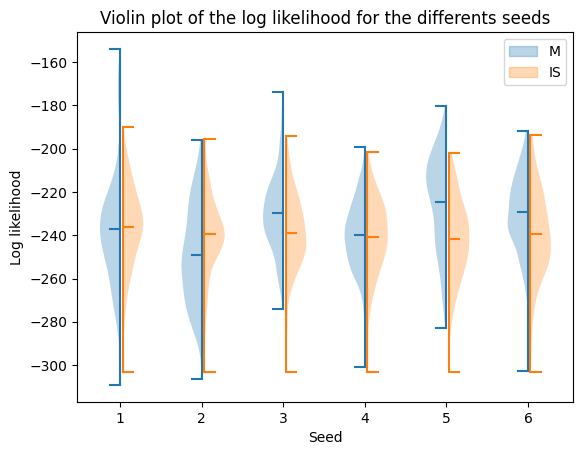

In [29]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
plt.figure()
color_m = plt.violinplot(all_likelihoods_m.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_m = matplotlib.patches.Patch(color=color_m)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_m, color_is], ["M", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

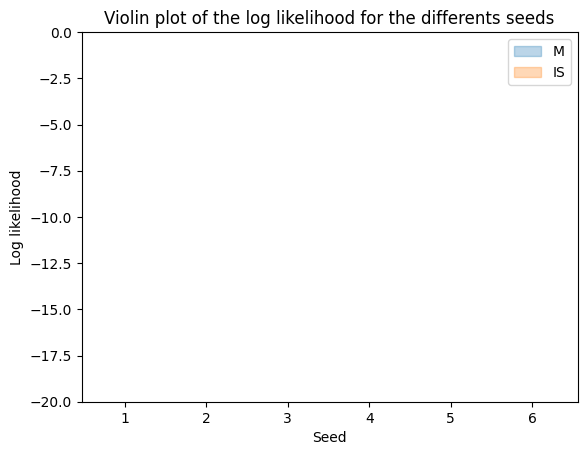

In [30]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
fig,ax = plt.subplots()
color_m = plt.violinplot(all_likelihoods_m.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_m = matplotlib.patches.Patch(color=color_m)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
ax.set_ylim(-20,0)
plt.legend([color_m, color_is], ["M", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

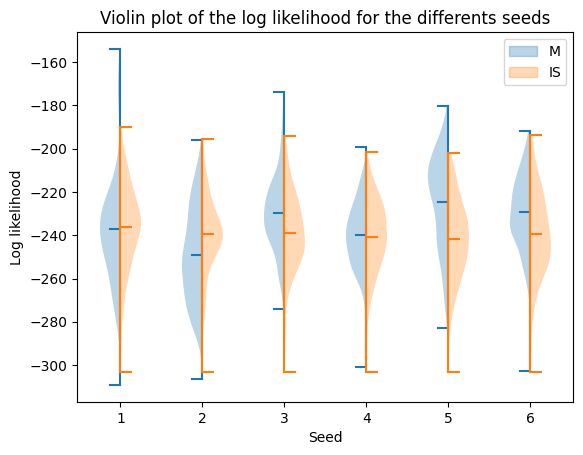

In [31]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms for high likelihoods
min_likelihood=-np.inf
high_likelihoods_m = [all_likelihoods_m[row][all_likelihoods_m[row] > min_likelihood] for row in range(len(all_likelihoods_m))]
high_likelihoods_is = [all_likelihoods_is[row][all_likelihoods_is[row] > min_likelihood] for row in range(len(all_likelihoods_is))]
fig,ax = plt.subplots()
color_m = plt.violinplot(high_likelihoods_m, showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_m = matplotlib.patches.Patch(color=color_m)
color_is = plt.violinplot(high_likelihoods_is, showmeans=True, side="high")["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_m, color_is], ["M", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

# Embeddings

In [32]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules_m.flatten(), all_rules_is.flatten()], axis=0))

### t-SNE

In [33]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

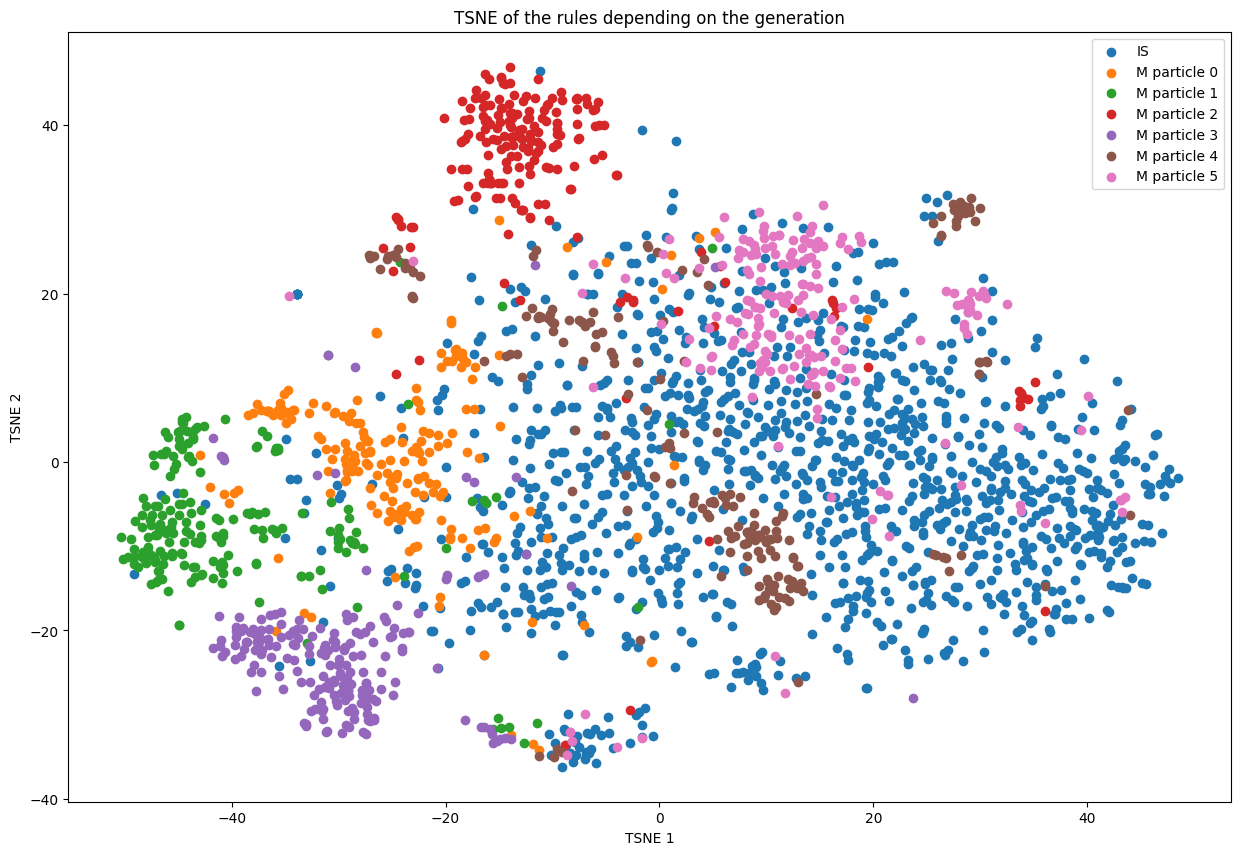

In [34]:
# Plot the embeddings
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[len(all_rules_m.flatten()):,0], proj_embeddings[len(all_rules_m.flatten()):,1], label="IS")
#Plot m particles
for i in range(all_rules_m.shape[0]):
    plt.scatter(proj_embeddings[i*all_rules_m.shape[1]: (i+1)*all_rules_m.shape[1],0], proj_embeddings[i*all_rules_m.shape[1]: (i+1)*all_rules_m.shape[1],1], label="M particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

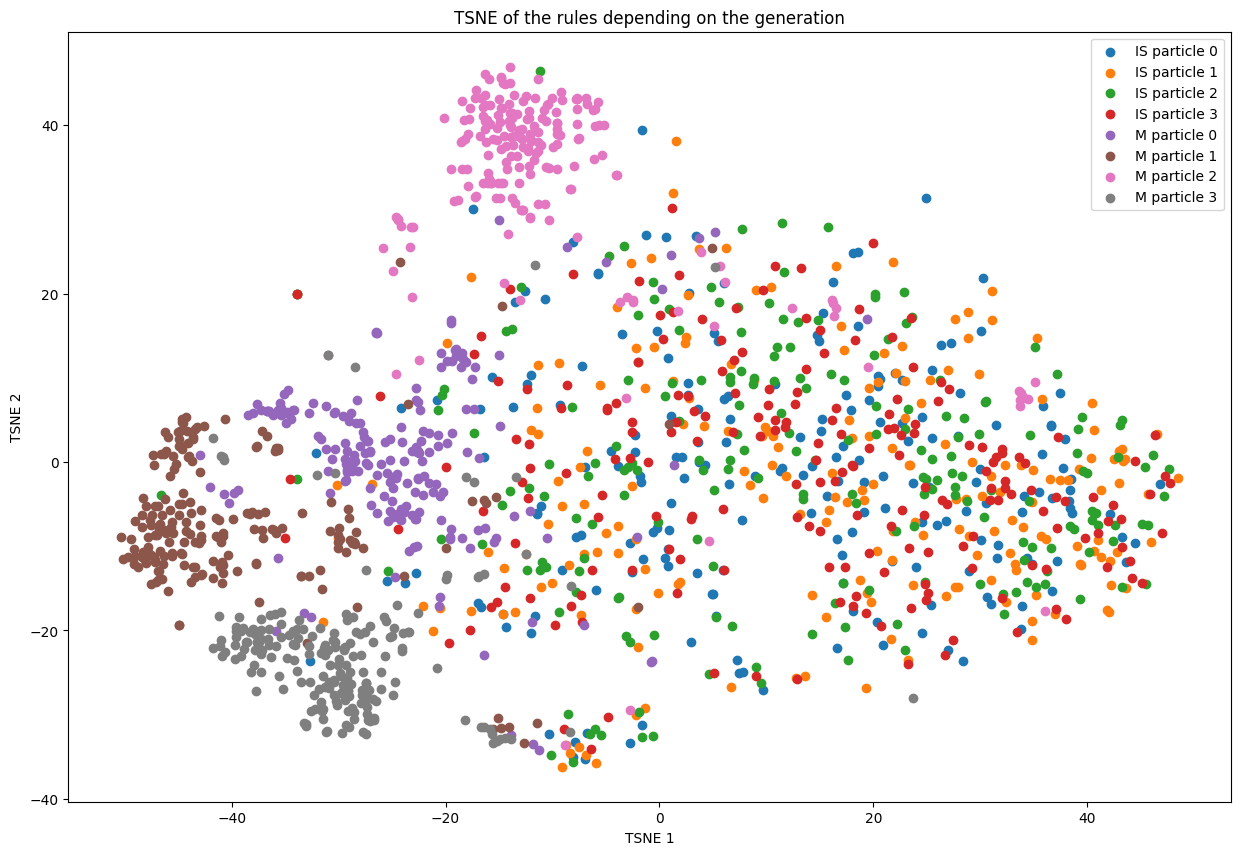

In [35]:
# Plot the embeddings
plt.figure(figsize=(15,10))
for i in range(4):
    plt.scatter(proj_embeddings[len(all_rules_m.flatten()) +i*all_rules_is.shape[1]: len(all_rules_m.flatten()) +(i+1)*all_rules_is.shape[1],0], proj_embeddings[len(all_rules_m.flatten()) +i*all_rules_is.shape[1]: len(all_rules_m.flatten()) +(i+1)*all_rules_is.shape[1],1], label="IS particle "+str(i))
# plt.scatter(proj_embeddings[len(all_rules_m.flatten()):,0], proj_embeddings[len(all_rules_m.flatten()):,1], label="IS")
#Plot Metropolis particles
for i in range(4):
    plt.scatter(proj_embeddings[i*all_rules_m.shape[1]: (i+1)*all_rules_m.shape[1],0], proj_embeddings[i*all_rules_m.shape[1]: (i+1)*all_rules_m.shape[1],1], label="M particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

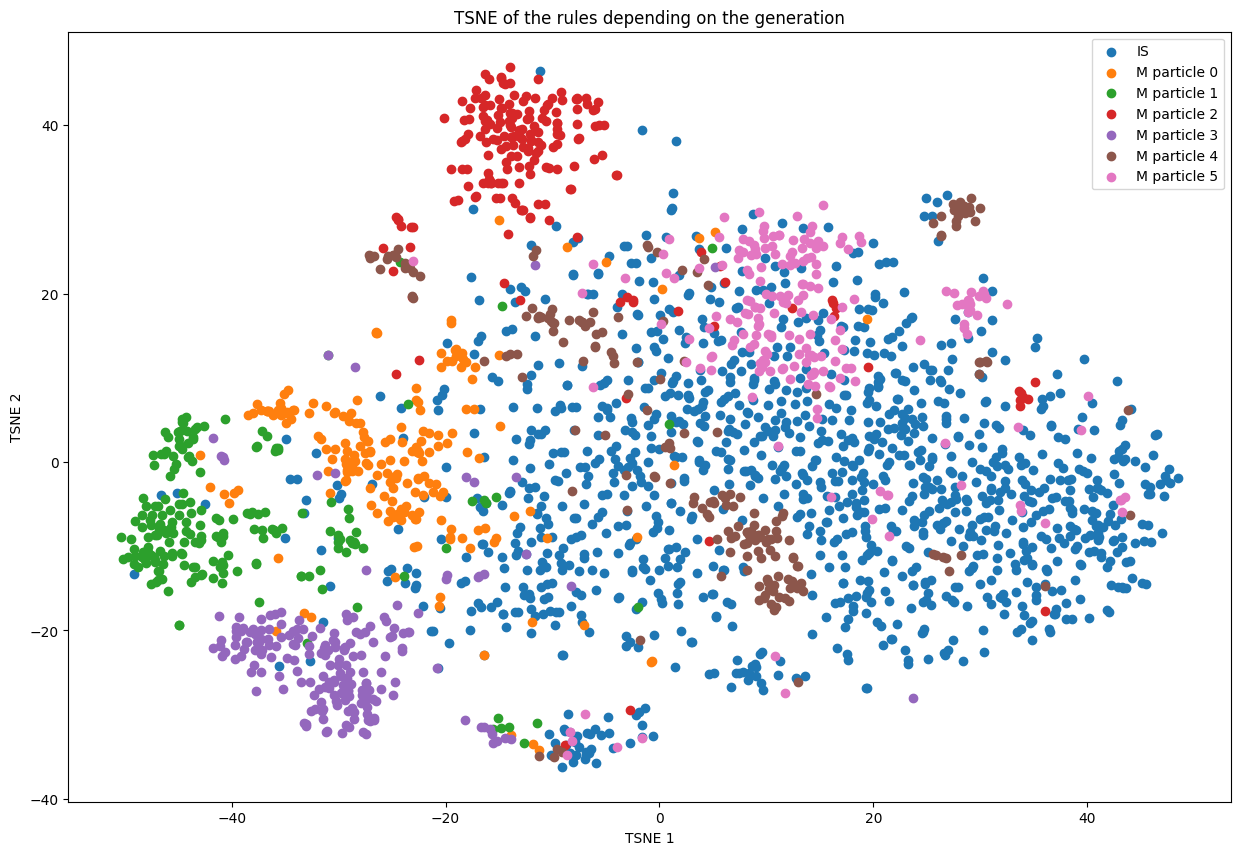

In [36]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
all_likelihoods = np.concatenate([all_likelihoods_m.flatten(), all_likelihoods_is.flatten()])
mask_likelihood = all_likelihoods > -300
mask_is = np.arange(len(all_likelihoods)) >= len(all_rules_m.flatten())
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[mask_likelihood&mask_is,0], proj_embeddings[mask_likelihood&mask_is,1], label="IS")
#Plot Metropolis particles
for i in range(len(all_rules_m)):
    mask_m = (np.arange(len(all_likelihoods)) < (i+1)*all_rules_m.shape[1]) & (np.arange(len(all_likelihoods)) >= i*all_rules_m.shape[1])
    plt.scatter(proj_embeddings[mask_likelihood&mask_m,0], proj_embeddings[mask_likelihood&mask_m,1], label="M particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

### PCA

In [37]:
#Compute the PCA embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_embeddings = pca.fit_transform(embeddings)

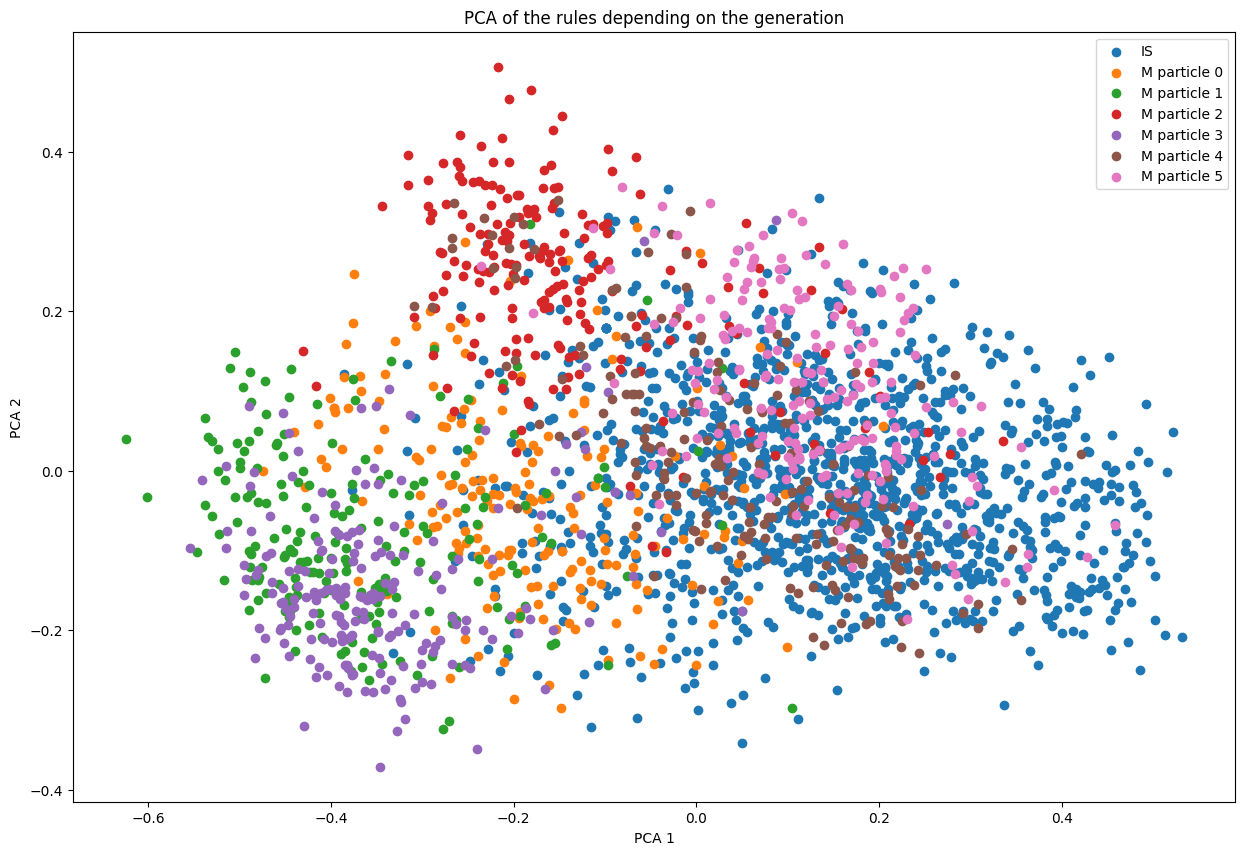

In [38]:
# Plot the embeddings
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[len(all_rules_m.flatten()):,0], proj_embeddings[len(all_rules_m.flatten()):,1], label="IS")
#Plot Metropolis particles
for i in range(len(all_rules_m)):
    plt.scatter(proj_embeddings[i*all_rules_m.shape[1]: (i+1)*all_rules_m.shape[1],0], proj_embeddings[i*all_rules_m.shape[1]: (i+1)*all_rules_m.shape[1],1], label="M particle "+str(i))
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()

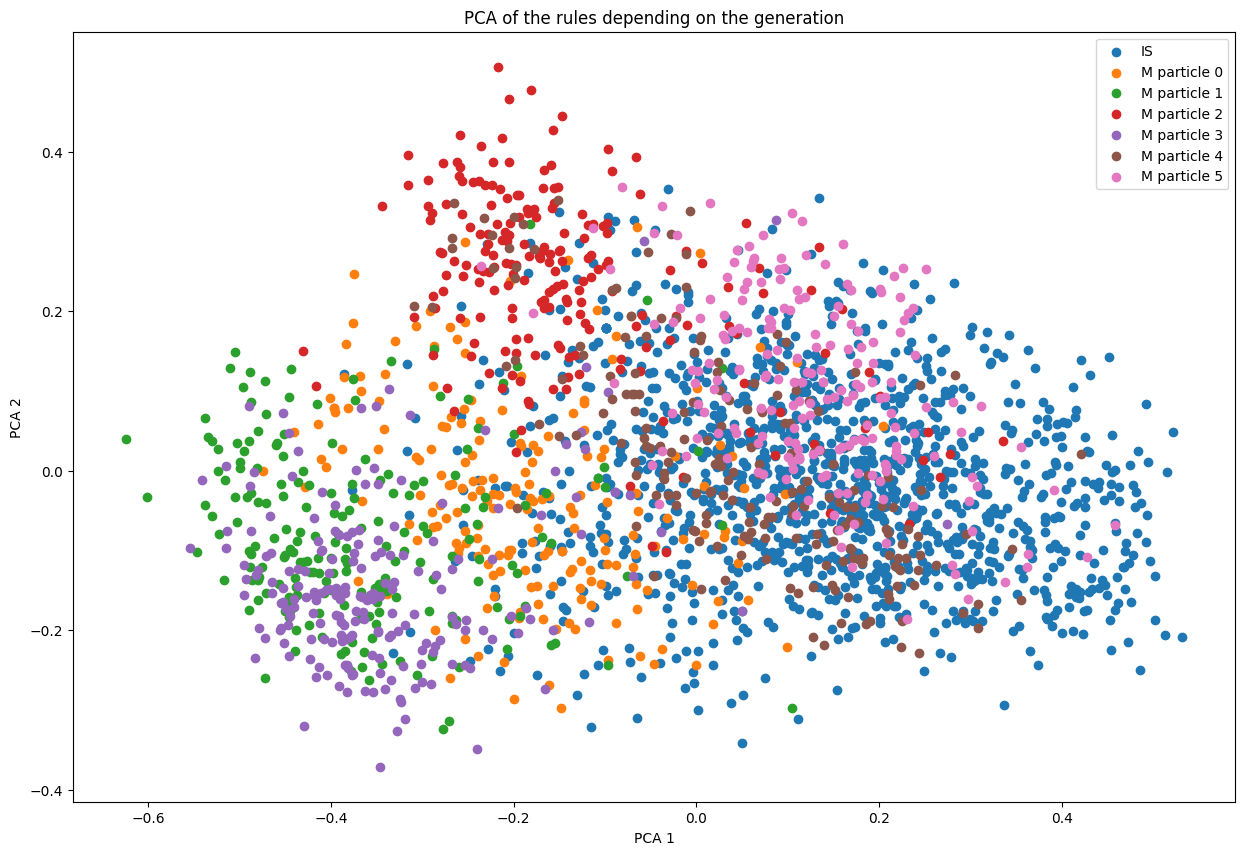

In [39]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
all_likelihoods = np.concatenate([all_likelihoods_m.flatten(), all_likelihoods_is.flatten()])
mask_likelihood = all_likelihoods > -400
mask_is = np.arange(len(all_likelihoods)) >= len(all_rules_m.flatten())
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[mask_likelihood&mask_is,0], proj_embeddings[mask_likelihood&mask_is,1], label="IS")
#Plot Metropolis particles
for i in range(len(all_rules_m)):
    mask_m = (np.arange(len(all_likelihoods)) < (i+1)*all_rules_m.shape[1]) & (np.arange(len(all_likelihoods)) >= i*all_rules_m.shape[1])
    plt.scatter(proj_embeddings[mask_likelihood&mask_m,0], proj_embeddings[mask_likelihood&mask_m,1], label="M particle "+str(i))
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()